In [1]:
!pip3 install tensorflow==2.2

  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Отказано в доступе: 'C:\\Users\\HoriFox\\anaconda3\\Lib\\site-packages\\~cipy\\cluster\\_hierarchy.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




Processing c:\users\horifox\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501\termcolor-1.1.0-py3-none-any.whl
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached protobuf-3.17.3-py2.py3-none-any.whl (173 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.0
    Uninstalling scipy-1.5.0:
      Successfully uninstalled scipy-1.5.0


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from IPython.display import Image
import scipy.stats as stats
%matplotlib inline 
sns.set(style="ticks")

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('car_ad2.csv' , encoding='latin-1')

In [7]:
data.head()

,car,price,body,mileage,engV,engType,year,model,drive,price_log,engV_log
0,Ford,15500.0,0,68,2.5,1,2010,Kuga,2,9.648595,0.916291
1,Mercedes-Benz,20500.0,3,173,1.8,1,2011,E-Class,3,9.928180,0.587787
2,Mercedes-Benz,35000.0,2,135,5.5,3,2008,CL 550,3,10.463103,1.704748
3,Mercedes-Benz,17800.0,5,162,1.8,0,2012,B 180,1,9.786954,0.587787
4,Nissan,16600.0,0,83,2.0,3,2013,X-Trail,2,9.717158,0.693147


In [8]:
data.shape

(8820, 11)

In [9]:
data_features = list(zip(
# признаки
[i for i in data.columns],
zip(
    # типы колонок
    [str(i) for i in data.dtypes],
    # проверим есть ли пропущенные значения
    [i for i in data.isnull().sum()]
)))
# Признаки с типом данных и количеством пропусков
data_features

[('car', ('object', 0)),
 ('price', ('float64', 0)),
 ('body', ('int64', 0)),
 ('mileage', ('int64', 0)),
 ('engV', ('float64', 0)),
 ('engType', ('int64', 0)),
 ('year', ('int64', 0)),
 ('model', ('object', 0)),
 ('drive', ('int64', 0)),
 ('price_log', ('float64', 0)),
 ('engV_log', ('float64', 0))]

In [10]:
from sklearn.preprocessing import LabelEncoder

In [12]:
data_encoded = data.copy()
columns = ['car', 'model']
for column in columns:
    label_encoder = LabelEncoder()
    data_encoded[column] = label_encoder.fit_transform(data_encoded[column])

In [14]:
data_encoded.head()

,car,price,body,mileage,engV,engType,year,model,drive,price_log,engV_log
0,23,15500.0,0,68,2.5,1,2010,473,2,9.648595,0.916291
1,50,20500.0,3,173,1.8,1,2011,320,3,9.928180,0.587787
2,50,35000.0,2,135,5.5,3,2008,228,3,10.463103,1.704748
3,50,17800.0,5,162,1.8,0,2012,197,1,9.786954,0.587787
4,55,16600.0,0,83,2.0,3,2013,820,2,9.717158,0.693147


In [20]:
def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=data_encoded.columns)
    return res

In [21]:
from sklearn.model_selection import train_test_split
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(data_encoded, data_encoded['body'],
                                                    test_size=0.2,
                                                    random_state=1)
# Преобразуем массивы в DataFrame
X_train_df = arr_to_df(X_train)
X_test_df = arr_to_df(X_test)

X_train_df.shape, X_test_df.shape, y_train.shape, y_test.shape

((7056, 11), (1764, 11), (7056,), (1764,))

In [22]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [51]:
class_models_dict = {
#                     'LinR': LinearRegression(), 
                    'SVR': SVR(),
                    'KNN_5':KNeighborsRegressor(n_neighbors=5),
#                     'Tree':DecisionTreeRegressor(random_state=1),
#                     'GB': GradientBoostingRegressor(random_state=1),
#                     'RF':RandomForestRegressor(n_estimators=50, random_state=1)
}

In [47]:
X_data_dict = {'Basic': (X_train_df, X_test_df)}

In [48]:
def test_models(class_models_dict, X_train, X_test, y_train, y_test):
    
    logger = MetricLogger()
    
    for model_name, model in class_models_dict.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        logger.add(model_name, 'Basic', mse)
            
    return logger

In [49]:
logger = test_models(class_models_dict, X_train_df, X_test_df, y_train, y_test)

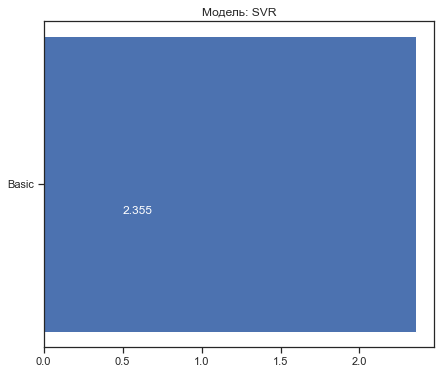

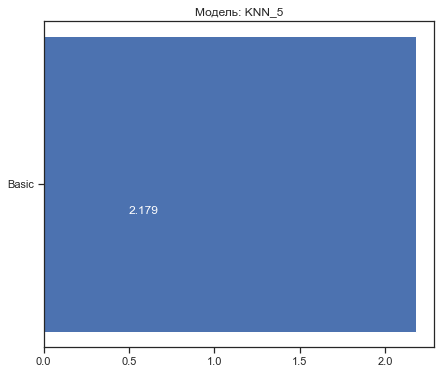

In [52]:
# Построим графики метрик качества модели
for model in class_models_dict:
    logger.plot('Модель: ' + model, model, figsize=(7, 6))